<a href="https://colab.research.google.com/github/emregulben/weather-prediction/blob/master/weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab/Weather/

[Errno 2] No such file or directory: 'drive/MyDrive/Colab/Weather/'
/content/drive/MyDrive/Colab/Weather


# My Model - Train

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
from math import floor
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create train, valid, test folders
os.chdir('Weather-Dataset')

if os.path.isdir('train/cloudy') is False:
    os.makedirs('train/cloudy')
    os.makedirs('train/rain')
    os.makedirs('train/shine')
    os.makedirs('train/sunrise')
    os.makedirs('valid/cloudy')
    os.makedirs('valid/rain')
    os.makedirs('valid/shine')
    os.makedirs('valid/sunrise')
    os.makedirs('test/cloudy')
    os.makedirs('test/rain')
    os.makedirs('test/shine')
    os.makedirs('test/sunrise')

    # Choose some for valid and test (70-20-10)
    num_of_valid = floor(len(glob.glob('cloudy*')) * 0.2)
    num_of_test = floor(num_of_valid/2)
    for c in random.sample(glob.glob('cloudy*'), num_of_valid):
        shutil.move(c, 'valid/cloudy')
    for c in random.sample(glob.glob('cloudy*'), num_of_test):
        shutil.move(c, 'test/cloudy')
    for c in glob.glob('cloudy*'):
        shutil.move(c, 'train/cloudy')

    num_of_valid = floor(len(glob.glob('rain*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('rain*'), num_of_valid):
        shutil.move(c, 'valid/rain')
    for c in random.sample(glob.glob('rain*'), num_of_test):
        shutil.move(c, 'test/rain')
    for c in glob.glob('rain*'):
        shutil.move(c, 'train/rain')

    num_of_valid = floor(len(glob.glob('shine*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('shine*'), num_of_valid):
        shutil.move(c, 'valid/shine')
    for c in random.sample(glob.glob('shine*'), num_of_test):
        shutil.move(c, 'test/shine')
    for c in glob.glob('shine*'):
        shutil.move(c, 'train/shine')

    num_of_valid = floor(len(glob.glob('sunrise*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('sunrise*'), num_of_valid):
        shutil.move(c, 'valid/sunrise')
    for c in random.sample(glob.glob('sunrise*'), num_of_test):
        shutil.move(c, 'test/sunrise')
    for c in glob.glob('sunrise*'):
        shutil.move(c, 'train/sunrise')


os.chdir('../')


# Preprocess
train_path = 'Weather-Dataset/train'
valid_path = 'Weather-Dataset/valid'
test_path = 'Weather-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10)

imgs, labels = next(train_batches)

# Plot Images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#plotImages(imgs)
#print(labels)


# Create-train model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=6, activation='softmax')
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model.fit(x=train_batches, validation_data=valid_batches, epochs=100, verbose=2, callbacks=[earlystopping])

# Save the model
if os.path.isfile('models/weather_model.h5') is False:
    model.save('models/weather_model.h5')



Found 1384 images belonging to 6 classes.
Found 392 images belonging to 6 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1204230   
Total params: 1,223,622
Trainable par

# My Model - Test

Found 197 images belonging to 6 classes.
{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3, 'snowy': 4, 'foggy': 5}
Confusion matrix, without normalization
[[28  2  0  0  0  0]
 [ 0 13  0  1  4  3]
 [ 8  1 16  0  0  0]
 [ 0  0  0 35  0  0]
 [ 3  3  0  0 32  5]
 [ 1  1  0  1  0 40]]


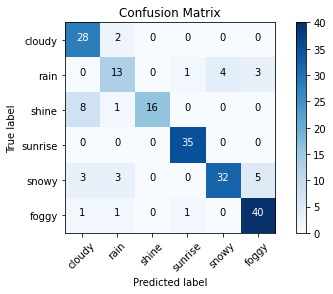

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load the model (trained, with weights)
from tensorflow.keras.models import load_model
model = load_model('models/weather_model.h5')


# Predict using the model
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='Weather-Dataset/test', target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10, shuffle=False)

test_imgs, test_labels = next(test_batches)    # Not shuffled


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


#plotImages(test_imgs)
#print(test_labels)


predictions = model.predict(x=test_batches, verbose=0)
#print('predictions = ', predictions)
rounded_predictions = np.round(predictions)     # Round the probabilities to 0 and 1
#print('rounded_predictions = ', rounded_predictions)


# Confusion Matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=predictions.argmax(axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


print(test_batches.class_indices)

cm_plot_labels = ['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.show()
# 97% accuracy on test set



# VGG16 - Train

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create train, valid, test folders
os.chdir('Weather-Dataset')

if os.path.isdir('train/cloudy') is False:
    os.makedirs('train/cloudy')
    os.makedirs('train/rain')
    os.makedirs('train/shine')
    os.makedirs('train/sunrise')
    os.makedirs('valid/cloudy')
    os.makedirs('valid/rain')
    os.makedirs('valid/shine')
    os.makedirs('valid/sunrise')
    os.makedirs('test/cloudy')
    os.makedirs('test/rain')
    os.makedirs('test/shine')
    os.makedirs('test/sunrise')

    # Choose some for valid and test (70-20-10)
    num_of_valid = floor(len(glob.glob('cloudy*')) * 0.2)
    num_of_test = floor(num_of_valid/2)
    for c in random.sample(glob.glob('cloudy*'), num_of_valid):
        shutil.move(c, 'valid/cloudy')
    for c in random.sample(glob.glob('cloudy*'), num_of_test):
        shutil.move(c, 'test/cloudy')
    for c in glob.glob('cloudy*'):
        shutil.move(c, 'train/cloudy')

    num_of_valid = floor(len(glob.glob('rain*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('rain*'), num_of_valid):
        shutil.move(c, 'valid/rain')
    for c in random.sample(glob.glob('rain*'), num_of_test):
        shutil.move(c, 'test/rain')
    for c in glob.glob('rain*'):
        shutil.move(c, 'train/rain')

    num_of_valid = floor(len(glob.glob('shine*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('shine*'), num_of_valid):
        shutil.move(c, 'valid/shine')
    for c in random.sample(glob.glob('shine*'), num_of_test):
        shutil.move(c, 'test/shine')
    for c in glob.glob('shine*'):
        shutil.move(c, 'train/shine')

    num_of_valid = floor(len(glob.glob('sunrise*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('sunrise*'), num_of_valid):
        shutil.move(c, 'valid/sunrise')
    for c in random.sample(glob.glob('sunrise*'), num_of_test):
        shutil.move(c, 'test/sunrise')
    for c in glob.glob('sunrise*'):
        shutil.move(c, 'train/sunrise')


os.chdir('../')

# Preprocess
train_path = 'Weather-Dataset/train'
valid_path = 'Weather-Dataset/valid'
test_path = 'Weather-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10)

imgs, labels = next(train_batches)

# Plot Images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#plotImages(imgs)
#print(labels)


# Make the layers of vgg16 not trainable and change the last layer for 2 outputs
vgg16_model = tf.keras.applications.vgg16.VGG16()
#vgg16_model.summary()

model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
#model.summary()

for layer in model.layers:
    layer.trainable = False

model.add(Dense(units=6, activation='softmax'))
#model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model.fit(x=train_batches, validation_data=valid_batches, epochs=100, verbose=2, callbacks=[earlystopping])

# Save the model
if os.path.isfile('models/weather_model_vgg.h5') is False:
    model.save('models/weather_model_vgg.h5')



Found 1384 images belonging to 6 classes.
Found 394 images belonging to 6 classes.
553467904/553467096 [==============================] - 5s 0us/step
Epoch 1/100
139/139 - 33s - loss: 1.2142 - accuracy: 0.5607 - val_loss: 0.5803 - val_accuracy: 0.7995
Epoch 2/100
139/139 - 24s - loss: 0.4970 - accuracy: 0.8266 - val_loss: 0.4185 - val_accuracy: 0.8655
Epoch 3/100
139/139 - 24s - loss: 0.3449 - accuracy: 0.8851 - val_loss: 0.3668 - val_accuracy: 0.8579
Epoch 4/100
139/139 - 24s - loss: 0.2673 - accuracy: 0.9198 - val_loss: 0.3253 - val_accuracy: 0.8832
Epoch 5/100
139/139 - 24s - loss: 0.2216 - accuracy: 0.9465 - val_loss: 0.3081 - val_accuracy: 0.8883
Epoch 6/100
139/139 - 24s - loss: 0.1914 - accuracy: 0.9494 - val_loss: 0.2841 - val_accuracy: 0.8934
Epoch 7/100
139/139 - 24s - loss: 0.1637 - accuracy: 0.9588 - val_loss: 0.2715 - val_accuracy: 0.8934
Epoch 8/100
139/139 - 24s - loss: 0.1435 - accuracy: 0.9668 - val_loss: 0.2621 - val_accuracy: 0.9036
Epoch 9/100
139/139 - 24s - loss: 

# VGG16 - Test

Found 197 images belonging to 6 classes.
{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3, 'snowy': 4, 'foggy': 5}
Confusion matrix, without normalization
[[28  1  1  0  0  0]
 [ 0 21  0  0  0  0]
 [ 1  0 23  1  0  0]
 [ 0  0  0 35  0  0]
 [ 1  0  1  0 40  1]
 [ 0  0  0  0  3 40]]


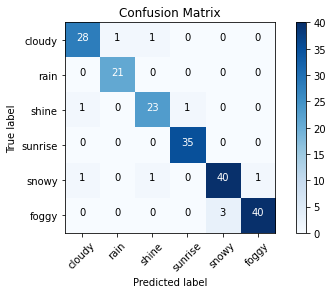

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load the model (trained, with weights)
from tensorflow.keras.models import load_model
model = load_model('models/weather_model_vgg.h5')


# Predict using the model
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='Weather-Dataset/test', target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10, shuffle=False)

test_imgs, test_labels = next(test_batches)    # Not shuffled


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


#plotImages(test_imgs)
#print(test_labels)


predictions = model.predict(x=test_batches, verbose=0)
#print('predictions = ', predictions)
rounded_predictions = np.round(predictions)     # Round the probabilities to 0 and 1
#print('rounded_predictions = ', rounded_predictions)


# Confusion Matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=predictions.argmax(axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


print(test_batches.class_indices)

cm_plot_labels = ['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.show()

# 96% accuracy on test set



# MobileNet - Train

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt


# Create train, valid, test folders
os.chdir('Weather-Dataset')

if os.path.isdir('train/cloudy') is False:
    os.makedirs('train/cloudy')
    os.makedirs('train/rain')
    os.makedirs('train/shine')
    os.makedirs('train/sunrise')
    os.makedirs('valid/cloudy')
    os.makedirs('valid/rain')
    os.makedirs('valid/shine')
    os.makedirs('valid/sunrise')
    os.makedirs('test/cloudy')
    os.makedirs('test/rain')
    os.makedirs('test/shine')
    os.makedirs('test/sunrise')

    # Choose some for valid and test (70-20-10)
    num_of_valid = floor(len(glob.glob('cloudy*')) * 0.2)
    num_of_test = floor(num_of_valid/2)
    for c in random.sample(glob.glob('cloudy*'), num_of_valid):
        shutil.move(c, 'valid/cloudy')
    for c in random.sample(glob.glob('cloudy*'), num_of_test):
        shutil.move(c, 'test/cloudy')
    for c in glob.glob('cloudy*'):
        shutil.move(c, 'train/cloudy')

    num_of_valid = floor(len(glob.glob('rain*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('rain*'), num_of_valid):
        shutil.move(c, 'valid/rain')
    for c in random.sample(glob.glob('rain*'), num_of_test):
        shutil.move(c, 'test/rain')
    for c in glob.glob('rain*'):
        shutil.move(c, 'train/rain')

    num_of_valid = floor(len(glob.glob('shine*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('shine*'), num_of_valid):
        shutil.move(c, 'valid/shine')
    for c in random.sample(glob.glob('shine*'), num_of_test):
        shutil.move(c, 'test/shine')
    for c in glob.glob('shine*'):
        shutil.move(c, 'train/shine')

    num_of_valid = floor(len(glob.glob('sunrise*')) * 0.2)
    num_of_test = floor(num_of_valid / 2)
    for c in random.sample(glob.glob('sunrise*'), num_of_valid):
        shutil.move(c, 'valid/sunrise')
    for c in random.sample(glob.glob('sunrise*'), num_of_test):
        shutil.move(c, 'test/sunrise')
    for c in glob.glob('sunrise*'):
        shutil.move(c, 'train/sunrise')


os.chdir('../')

# Preprocess
train_path = 'Weather-Dataset/train'
valid_path = 'Weather-Dataset/valid'
test_path = 'Weather-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10)


# Fine-tune
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

x = mobile.layers[-6].output
output = Dense(units=6, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=output)

for layer in model.layers[:-23]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# More epochs (~30), better results
earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model.fit(x=train_batches, validation_data=valid_batches, epochs=100, verbose=2, callbacks=[earlystopping])

# Save the model
if os.path.isfile('models/weather_model_mobilenet.h5') is False:
    model.save('models/weather_model_mobilenet.h5')



Found 1384 images belonging to 6 classes.
Found 394 images belonging to 6 classes.
17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (No

# MobileNet - Test

Found 197 images belonging to 6 classes.
Confusion matrix, without normalization
[[30  0  0  0  0  0]
 [ 0 21  0  0  0  0]
 [ 1  0 24  0  0  0]
 [ 0  0  0 35  0  0]
 [ 0  1  0  0 40  2]
 [ 0  0  0  0  0 43]]


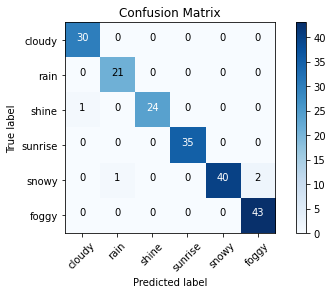

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt


# Load the model (trained, with weights)
from tensorflow.keras.models import load_model
model = load_model('models/weather_model_mobilenet.h5')


# Predict using the model
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory='Weather-Dataset/test', target_size=(224,224), classes=['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy'], batch_size=10, shuffle=False)

test_imgs, test_labels = next(test_batches)    # Not shuffled

# Predict
predictions = model.predict(x=test_batches, verbose=0)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


test_labels = test_batches.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=-1))

# test_batches.class_indices     # Prints: {'cloudy' : 0, 'rain' : 1, 'shine' : 2, 'sunrise' : 3}

cm_plot_labels = ['cloudy', 'rain', 'shine', 'sunrise', 'snowy', 'foggy']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.show()

# 95% accuracy on test set



# Predict my image

In [ ]:
!ls my_images/

cloudcomputing_article_001.jpg			      sunflower.jpg
little-girl-red-umbrella-playing-260nw-307434563.jpg  sunrising.jpg


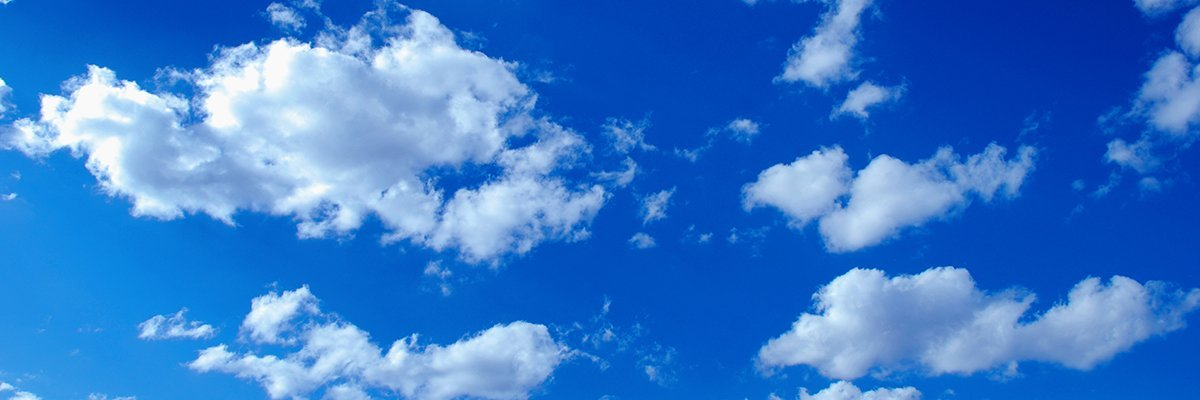

cloudy:  0.08540682
rain:  0.055534877
shine:  0.09515648
sunrise:  0.76390177


In [ ]:
# Preprocess image
from tensorflow.keras.preprocessing import image

def prepare_image(file):
    #img_path = 'my_images/'
    img = image.load_img(file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

# Display image
from IPython.display import Image, display
image_name = 'my_images/cloudcomputing_article_001.jpg'
display(Image(filename=image_name, width=300, height=200))


# Predict
preprocessed_image = prepare_image(image_name)
predictions = model.predict(preprocessed_image)

def print_pred(predictions):
    print('cloudy: ', predictions[0][0])
    print('rain: ', predictions[0][1])
    print('shine: ', predictions[0][2])
    print('sunrise: ', predictions[0][3])
    print('snowy: ', predictions[0][4])
    print('foggy: ', predictions[0][5])

print_pred(predictions)